In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import numpy as np


### Plot data and decision boundaries for 2 dimensions

In [ ]:
qda = pkl.load(open("./results/gemma-2-2b/projected_shades_reformated_qda.pkl", "rb"))
data = pd.read_csv("./results/gemma-2-2b/projected_shades_reformated.csv")

data = data[data["class"] != "probable"]

features = data[["improbable_impossible", "impossible_inconceivable"]]
classes = data["class"]
sentences = data["sentence"]

clf_classes = qda.classes_
print(clf_classes)
distributions = qda.predict_proba(features)

['impossible' 'improbable' 'inconceivable']


/gpfs/data/epavlick/mlepori/miniconda3/envs/content_effects/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuadraticDiscriminantAnalysis was fitted with feature names
  warnings.warn(


(100, 100)


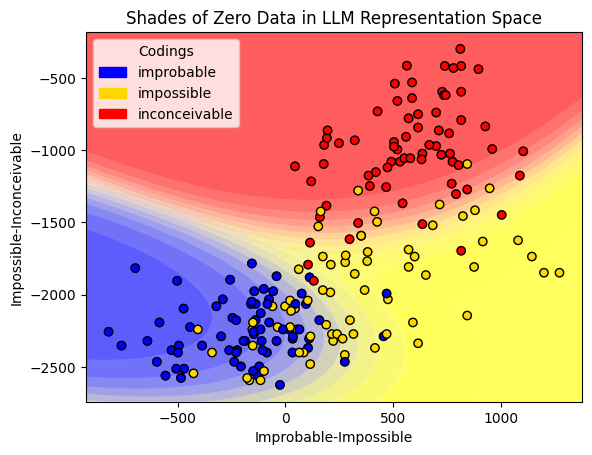

In [ ]:
import matplotlib.patches as mpatches

plt.Figure()

fig, ax = plt.subplots()

colors = []
for cl in classes:
    if cl == "improbable":
        colors.append("blue")

    if cl == "impossible":
        colors.append("gold")
    
    if cl == "inconceivable":
        colors.append("red")

legend_colors = {
    'improbable': 'blue',
    'impossible': 'gold',
    'inconceivable': 'red'
}

# Create legend patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]

ax.scatter(x=features["improbable_impossible"], y=features["impossible_inconceivable"], c=colors)
plt.legend(handles=legend_handles, title="Codings")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100),
    np.linspace(ylim[0], ylim[1], 100)
)

grid_points = np.c_[xx.ravel(), yy.ravel()] 
bg_probs = qda.predict_proba(grid_points)

impossible_bg_probs = bg_probs[:, 0].reshape(xx.shape)
print(impossible_bg_probs.shape)
improbable_bg_probs = bg_probs[:, 1].reshape(xx.shape)
inconceivable_bg_probs = bg_probs[:, 2].reshape(xx.shape)

# Loop over probability levels and draw a contour layer for each
levels = np.linspace(0.01, 0.9, 10)
for level in levels:
    ax.contourf(xx, yy, impossible_bg_probs,
                levels=[level, 1],
                colors='yellow',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    ax.contourf(xx, yy, improbable_bg_probs,
                levels=[level, 1],
                colors='blue',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    ax.contourf(xx, yy, inconceivable_bg_probs,
                levels=[level, 1],
                colors='red',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    
ax.scatter(x=features["improbable_impossible"], y=features["impossible_inconceivable"], c=colors, edgecolors="black")
plt.title("Shades of Zero Data in LLM Representation Space")
plt.ylabel("Impossible-Inconceivable")
plt.xlabel("Improbable-Impossible")
plt.savefig("./results/gemma-2-2b/shades_regions.pdf", format="pdf")

### Plot correlation between entropy of QDA distribution and entropy of response distribution

Fit QDA on all three dimensions for this

140
68
72
0.7


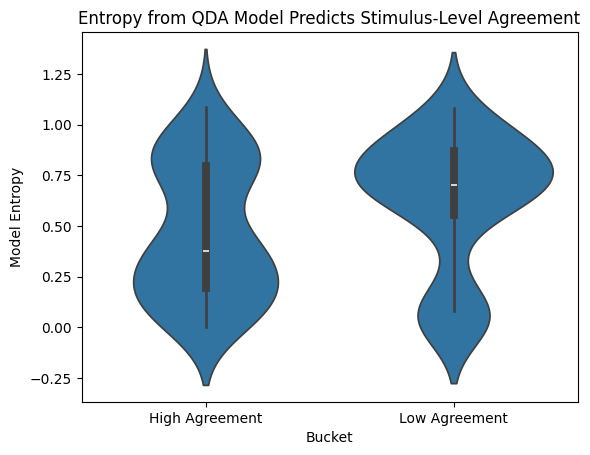

In [41]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats

qda = QuadraticDiscriminantAnalysis()
data = pd.read_csv("./results/gemma-2-2b/projected_shades_reformated.csv")

features = data[["probable_improbable", "improbable_impossible", "impossible_inconceivable"]]
classes = data["class"]

qda.fit(features, classes)

sentences = data["sentence"]
distributions = qda.predict_proba(features)

human_data = pd.read_csv("../../data/shades_exp1_human_data.csv")
human_data = human_data[["query", "response_label"]]

human_queries = human_data.groupby("query")
human_labels = ["probable", "improbable", "impossible", "nonsense"]

human_buckets = []
model_entropies = []

for query, grp in human_queries:
    total = len(grp)
    cls_counts = []

    for lab in human_labels:
        cls_counts.append(np.sum(grp["response_label"] == lab))
    dist = np.array(cls_counts)/total

    if np.max(dist) < .66:
        human_buckets.append("Low Agreement")
    elif np.max(dist) > .95:
        human_buckets.append("High Agreement")
    else:
        human_buckets.append("Mid")

    query = query.lower() + "."
    query = query.replace("your", "their")

    for i, sent in enumerate(sentences):
        if sent == query:
            model_entropy = stats.entropy(distributions[i])
            model_entropies.append(model_entropy)

plot_data = pd.DataFrame.from_dict({
    "Model Entropy": model_entropies,
    "Bucket": human_buckets
})
plot_data = plot_data[plot_data["Bucket"] != "Mid"]

sns.violinplot(data=plot_data, x="Bucket", y="Model Entropy", inner="box")
plt.title("Entropy from QDA Model Predicts Stimulus-Level Agreement")
plt.savefig("./results/gemma-2-2b/Entropy_Agreement.pdf", bbox_inches="tight", format="pdf")

print(len(plot_data["Bucket"]))
print(np.sum((plot_data["Bucket"] == "High Agreement")))
print(np.sum((plot_data["Bucket"] == "Low Agreement")))

predictions = LogisticRegression().fit(plot_data["Model Entropy"].to_numpy().reshape(-1, 1), plot_data["Bucket"]).predict(plot_data["Model Entropy"].to_numpy().reshape(-1, 1))
accuracy = np.mean([pred == plot_data["Bucket"].iloc[i] for i, pred in enumerate(predictions)])
print(accuracy)

### Use QDA classifier trained on shades data to analyze classic data from Shtulman and Carey

In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import matplotlib.patches as mpatches


data = pd.read_csv("./results/gemma-2-2b/projected_shtulman_carey.csv")

features = data[["probable_improbable", "improbable_impossible", "impossible_inconceivable"]]
classes = data["class"]
sentences = data["sentence"]

preds = qda.predict(features)
print(qda.score(features, classes))
print(preds)
print(sentences)

plt.Figure()

fig, ax = plt.subplots()

colors = []
for cl in classes:
    if cl == "improbable":
        colors.append("blue")

    if cl == "impossible":
        colors.append("gold")
    
    if cl == "probable":
        colors.append("red")

legend_colors = {
    'improbable': 'blue',
    'impossible': 'gold',
    'probable': 'red'
}

# Create legend patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]

ax.scatter(x=features["probable_improbable"], y=features["improbable_impossible"], c=colors)
plt.legend(handles=legend_handles, title="Codings")

distributions = qda.predict_proba(features)



ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- impossible_inconceivable


['impossible' 'improbable' 'probable']
0.6666666666666666
(100, 100)


/gpfs/data/epavlick/mlepori/miniconda3/envs/content_effects/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


0.027784490019077138


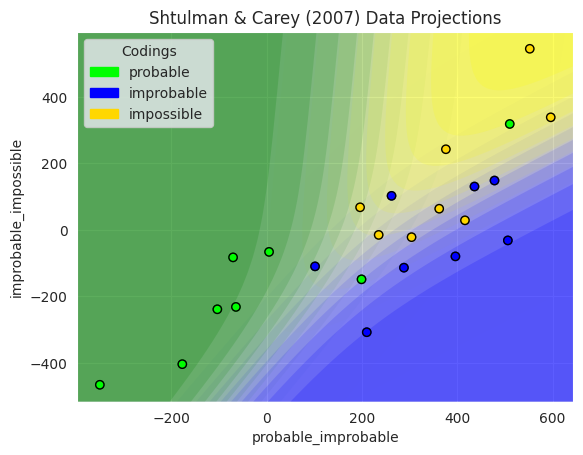

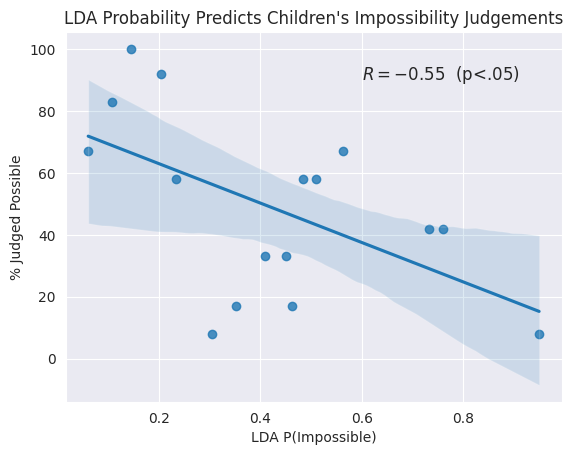

In [83]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
sns.set_style('darkgrid')

lda = LinearDiscriminantAnalysis()
data = pd.read_csv("./results/gemma-2-2b/projected_shtulman_carey.csv")

features = data[["probable_improbable", "improbable_impossible"]]
classes = data["class"]
sentences = data["sentence"]
lda.fit(features, classes)

print(lda.classes_)
print(lda.score(features, classes))

# Plot Projections and LDA spaces
plt.Figure()

fig, ax = plt.subplots()

colors = []
for cl in classes:
    if cl == "improbable":
        colors.append("blue")

    if cl == "impossible":
        colors.append("gold")
    
    if cl == "probable":
        colors.append("lime")

legend_colors = {
    'probable': 'lime',
    'improbable': 'blue',
    'impossible': 'gold',
}

# Create legend patches
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in legend_colors.items()]
ax.scatter(x=features["probable_improbable"], y=features["improbable_impossible"], c=colors)
plt.legend(handles=legend_handles, title="Codings")

xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(
    np.linspace(xlim[0], xlim[1], 100),
    np.linspace(ylim[0], ylim[1], 100)
)

grid_points = np.c_[xx.ravel(), yy.ravel()] 
bg_probs = lda.predict_proba(grid_points)

impossible_bg_probs = bg_probs[:, 0].reshape(xx.shape)
print(impossible_bg_probs.shape)
improbable_bg_probs = bg_probs[:, 1].reshape(xx.shape)
probable_bg_probs = bg_probs[:, 2].reshape(xx.shape)

# Loop over probability levels and draw a contour layer for each
levels = np.linspace(0.01, 0.9, 10)
for level in levels:
    ax.contourf(xx, yy, improbable_bg_probs,
                levels=[level, 1],
                colors='blue',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    ax.contourf(xx, yy, probable_bg_probs,
                levels=[level, 1],
                colors='green',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)
    ax.contourf(xx, yy, impossible_bg_probs,
                levels=[level, 1],
                colors='yellow',
                alpha=level/5,  # alpha increases with probability
                antialiased=True)

ax.scatter(x=features["probable_improbable"], y=features["improbable_impossible"], c=colors, edgecolors="black")
plt.title("Shtulman & Carey (2007) Data Projections")
plt.xlabel("probable_improbable")
plt.ylabel("improbable_impossible")
plt.savefig("./results/gemma-2-2b/shtulman_carey_projections.pdf", format="pdf", bbox_inches="tight")

# Get correlation with developmental data judgements
not_probable_data = data[data["class"] != "probable"]
distributions = lda.predict_proba(not_probable_data[["probable_improbable", "improbable_impossible"]])
impossible_probability = distributions[:, (lda.classes_ == "impossible")]
r, sig = stats.pearsonr(impossible_probability.reshape(-1), not_probable_data["rating"])
print(sig)

plt.figure()
sns.regplot(x=impossible_probability, y=not_probable_data["rating"] * 100)
plt.ylabel("% Judged Possible")
plt.xlabel("LDA P(Impossible)")
plt.title("LDA Probability Predicts Children's Impossibility Judgements")
plt.text(max(impossible_probability) - .35, max(not_probable_data["rating"] * 100) - 10, f'$R = {r:.2f}$  (p<.05)', fontsize=12)
plt.savefig("./results/gemma-2-2b/correlation.pdf", format="pdf", bbox_inches="tight")
